# Training Notebook : Mamos Project Detecting CC and MLO

El siguiente notebook se utiliza para el entrenamiento de modelos predictivos de Mamografías

### Importamos las librerías a utilizar

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from BasisModels import BasisModels as bm

### Cargamos los Datos

In [2]:
df = pd.read_pickle("CBIS/Fullmamo.pkl")

In [3]:
df['y'] = df['y'].apply(lambda x: str(x))

In [4]:
df.groupby("Exam Type").size()

Exam Type
CC     1461
MLO    1643
dtype: int64

### Data Split

In [5]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(df, test_size = 0.20 , random_state=42)
val, test = train_test_split(val, test_size = 0.50 , random_state=42)

### Instanciamos un Generador

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255.)

In [7]:
train.head()

,Patient_ID,Data Description URI,Study Type,File Location,File Path,Orientation,Exam Type,Patologia,MainPath,y,Index
5357,P_00894,Mass-Training_P_00894_RIGHT_MLO,full mammogram images,./CBIS-DDSM/Mass-Training_P_00894_RIGHT_MLO/07...,CBIS-DDSM/Mass-Training_P_00894_RIGHT_MLO/07-2...,Right,MLO,Mass,CBIS-DDSM/Mass-Training_P_00894_RIGHT_MLO/07-2...,0,Mamo1432.png
5138,P_00732,Mass-Training_P_00732_LEFT_MLO,full mammogram images,./CBIS-DDSM/Mass-Training_P_00732_LEFT_MLO/07-...,CBIS-DDSM/Mass-Training_P_00732_LEFT_MLO/07-20...,Left,MLO,Mass,CBIS-DDSM/Mass-Training_P_00732_LEFT_MLO/07-20...,0,Mamo1177.png
4287,P_00106,Mass-Training_P_00106_RIGHT_MLO,full mammogram images,./CBIS-DDSM/Mass-Training_P_00106_RIGHT_MLO/07...,CBIS-DDSM/Mass-Training_P_00106_RIGHT_MLO/07-2...,Right,MLO,Mass,CBIS-DDSM/Mass-Training_P_00106_RIGHT_MLO/07-2...,0,Mamo168.png
6377,P_01638,Mass-Training_P_01638_RIGHT_MLO,full mammogram images,./CBIS-DDSM/Mass-Training_P_01638_RIGHT_MLO/07...,CBIS-DDSM/Mass-Training_P_01638_RIGHT_MLO/07-2...,Right,MLO,Mass,CBIS-DDSM/Mass-Training_P_01638_RIGHT_MLO/07-2...,0,Mamo2593.png
602,P_02498,Calc-Test_P_02498_RIGHT_CC,full mammogram images,./CBIS-DDSM/Calc-Test_P_02498_RIGHT_CC/08-29-2...,CBIS-DDSM/Calc-Test_P_02498_RIGHT_CC/08-29-201...,Right,CC,Calc,CBIS-DDSM/Calc-Test_P_02498_RIGHT_CC/08-29-201...,1,Mamo3084.png


In [8]:
train_generator=datagen.flow_from_dataframe( 
dataframe=train,
directory= 'CBIS/Png/',
x_col='Index',
y_col='y',
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(224,224))


valid_generator=datagen.flow_from_dataframe(
dataframe=val,
directory= 'CBIS/Png/',
x_col='Index',
y_col='y',
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 2483 validated image filenames belonging to 2 classes.
Found 310 validated image filenames belonging to 2 classes.


### Instanciamos un Modelo Base

Utilizamos __BasisModels__ para instanciar una base para crear el modelo. Para ver los modelos disponibles utilizamos __AvailableModels__

In [9]:
bm.AvailableModels()

['VGG16', 'VGG19', 'DENSENET121', 'RESNET50', 'INCEPTIONV3', 'INCEPTIONRESNETV2', 'NASNETMOBILE', 'NASNETLARGE']


Generamos la base y guardamos el __input_shape__ de las imágenes

In [10]:
modelobase = bm("RESNET50")
input_shape = modelobase.GetInputShape()
dn = modelobase.BuildBasisModel()

2021-11-22 10:58:01.247413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 10:58:01.252777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 10:58:01.253112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-22 10:58:01.254065: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

RESNET50 model created


In [11]:
input_shape

(224, 224, 3)

### Agregamos ahora detalles del output del modelo

In [12]:
output_neurons = 2 # depende del número de clases que se quieren predecir
output_activation = "softmax" # puede ser sigmoid cuando hay una sola neurona o softmax cuando hay 2 o mas
loss_function = "categorical_crossentropy" 
# Si el output es una sola dimensión es decir 1 o 0 , usamos binary_crossentropy. Si el output es en formato one-hot, es decir , [1 , 0] , entonces usamos
# categorical_crossentropy. Finalmente si tenemos varias categorías en formato no one hot usamos sparse_categorical_crossentropy
learning_rate = 0.001 # valor del learning rate, no se usa en todos los optimizadores
optimizer = "adam"

### Construimos la parte superior del modelo (clasificación)

In [13]:
headmodel = dn.output
headmodel = tf.keras.layers.AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = tf.keras.layers.Flatten(name= 'flatten')(headmodel)
headmodel = tf.keras.layers.Dense(256, activation = "relu")(headmodel)
headmodel = tf.keras.layers.Dropout(0.3)(headmodel)#
headmodel = tf.keras.layers.Dense(256, activation = "relu")(headmodel)
headmodel = tf.keras.layers.Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(2, activation = 'softmax')(headmodel)

model = tf.keras.models.Model(inputs = dn.input, outputs = headmodel)

### Compilamos el Modelo

En ésta sección compilamos el modelo, donde utilizamos algunas variables previamente diseñadas

In [14]:
model.compile(
    loss = "categorical_crossentropy" ,
    optimizer = "adam" ,
    metrics = ["accuracy"] 
)

In [15]:
history = model.fit(train_generator, epochs = 10, validation_data = valid_generator)

2021-11-22 10:58:23.509862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-11-22 10:58:29.768355: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


156/156 [==============================] - 384s 2s/step - loss: 0.5897 - accuracy: 0.8417 - val_loss: 1.6919 - val_accuracy: 0.4806
Epoch 2/10
156/156 [==============================] - 367s 2s/step - loss: 0.1069 - accuracy: 0.9774 - val_loss: 3.6529 - val_accuracy: 0.4806
Epoch 3/10
156/156 [==============================] - 360s 2s/step - loss: 0.0943 - accuracy: 0.9766 - val_loss: 0.1306 - val_accuracy: 0.9645
Epoch 4/10
156/156 [==============================] - 362s 2s/step - loss: 0.0897 - accuracy: 0.9811 - val_loss: 0.0275 - val_accuracy: 0.9935
Epoch 5/10
156/156 [==============================] - 359s 2s/step - loss: 0.0741 - accuracy: 0.9787 - val_loss: 0.0786 - val_accuracy: 0.9839
Epoch 6/10
156/156 [==============================] - 357s 2s/step - loss: 0.0616 - accuracy: 0.9863 - val_loss: 0.1939 - val_accuracy: 0.9548
Epoch 7/10
156/156 [==============================] - 361s 2s/step - loss: 0.1078 - accuracy: 0.9783 - val_loss: 2.7859 - val_accuracy: 0.9194
Epoch 8/10

In [16]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))


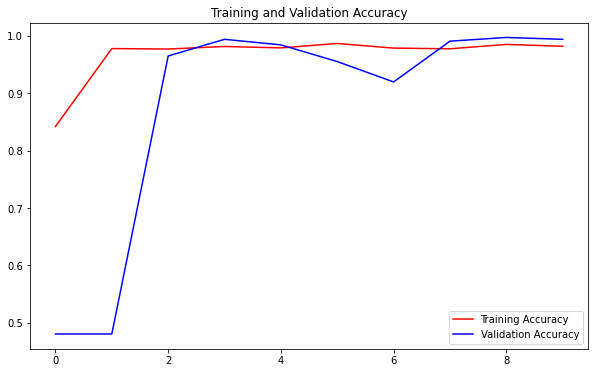

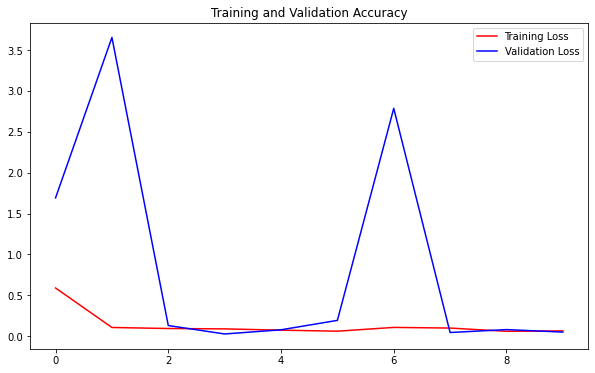

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
plt.plot(epochs, accuracy, 'r' , label = "Training Accuracy")
plt.plot(epochs, val_accuracy, 'b' , label = 'Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure(figsize = (10,6))
plt.plot(epochs, loss, 'r' , label = "Training Loss")
plt.plot(epochs, val_loss, 'b' , label = 'Validation Loss')
plt.title("Training and Validation Accuracy")
plt.legend()

In [18]:
model.save("CCMLO2")

2021-11-22 12:01:32.801569: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: CCMLO2/assets


/home/marcelo/anaconda3/envs/atrys/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [19]:
test_generator=datagen.flow_from_dataframe(
dataframe=test,
directory= 'CBIS/Png/',
x_col='Index',
y_col='y',
batch_size=16,
shuffle=False,
class_mode="categorical",
target_size=(224,224))

Found 311 validated image filenames belonging to 2 classes.


In [20]:
test_predict = model.predict(test_generator, verbose =1)

20/20 [==============================] - 40s 2s/step


In [21]:
test_predict.shape

(311, 2)

In [22]:
# Obtain the predicted class from the model prediction
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [23]:
predict

array(['0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0',
       '1', '0', '1', '0', '0', '0', '1', '1', '1', '1', '1', '0', '0',
       '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0',
       '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0',
       '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0',
       '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1',
       '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '1', '1', '1', '1', '1', '1', '0', '0', '0',
       '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0',
       '0', '1', '0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0',
       '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '0',
       '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0

In [24]:
test['y'].values

array(['0', '1', '1', '0', '1', '1', '0', '0', '0', '0', '0', '0', '1',
       '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1', '0',
       '1', '1', '1', '0', '0', '0', '1', '1', '1', '1', '1', '0', '0',
       '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0',
       '1', '0', '1', '0', '1', '1', '1', '0', '0', '1', '1', '0', '0',
       '1', '0', '1', '0', '1', '0', '0', '0', '0', '1', '1', '0', '0',
       '1', '1', '0', '1', '1', '0', '1', '0', '0', '0', '1', '0', '1',
       '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '1', '1', '0', '0', '1', '1', '1', '0', '1', '1', '0', '0', '0',
       '1', '1', '1', '0', '0', '0', '0', '0', '1', '1', '1', '0', '0',
       '0', '1', '1', '1', '1', '0', '1', '1', '0', '0', '0', '0', '1',
       '0', '0', '0', '1', '1', '1', '1', '0', '0', '1', '1', '1', '0',
       '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '0', '1', '1',
       '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , accuracy_score,precision_score,recall_score, classification_report

In [26]:
def buildCM(df , gt , prediction , output_order_x , output_order_y):
    """
    Returns a confusion matrix and some metrics such as Precision, Recall and F1-Score , per class
    
    ARGS:
        df: Dataframe with data
        gt: Ground Truth Column
        prediction: Prediction Column 
    """
    import seaborn as sns
    cm = confusion_matrix(df[gt] , df[prediction])
    plt.figure(figsize = (10,7))
    sns.heatmap(cm , xticklabels = output_order_x , yticklabels = output_order_y , annot = True , fmt='g')
    plt.xlabel("Predictions" , fontsize = 15) 
    plt.ylabel("Ground Truth" , fontsize = 15) 
    print(classification_report(df[gt]  , df[prediction]))
    print(accuracy_score(df[gt] , df[prediction]))

In [27]:
test['Predict'] = predict

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       169
           1       0.99      0.97      0.98       142

    accuracy                           0.98       311
   macro avg       0.98      0.98      0.98       311
weighted avg       0.98      0.98      0.98       311

0.9807073954983923


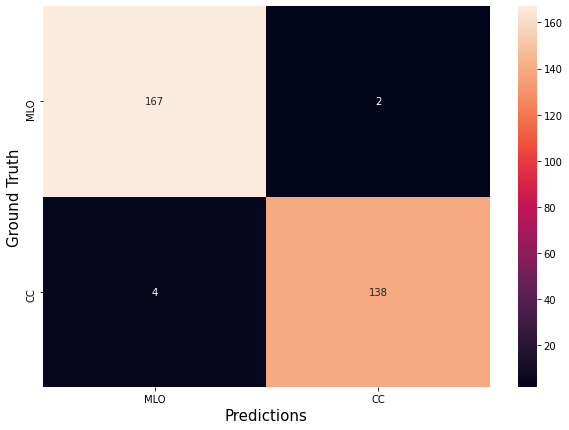

In [29]:
buildCM(test , "y" , "Predict" , ["MLO" , "CC"] , ["MLO" , "CC"])

In [30]:
test.groupby(["y" , "Predict"]).size()

y  Predict
0  0          167
   1            2
1  0            4
   1          138
dtype: int64

### Plotting some Random Images and Predictions

In [31]:
amax = np.argmax(test_predict , axis = 1)

In [32]:
amax

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,

In [33]:
probs = []
for c,i in enumerate(amax):
    probs.append(test_predict[c][i])

In [34]:
test['Confidence'] = probs

In [35]:
predlabel = []
for x in test['Predict'].values:
    if x == "1":
        predlabel.append("CC")
    else:
        predlabel.append("MLO")

In [36]:
test['PredLabel'] = predlabel

In [37]:
test.iloc[0]['Exam Type']

'MLO'

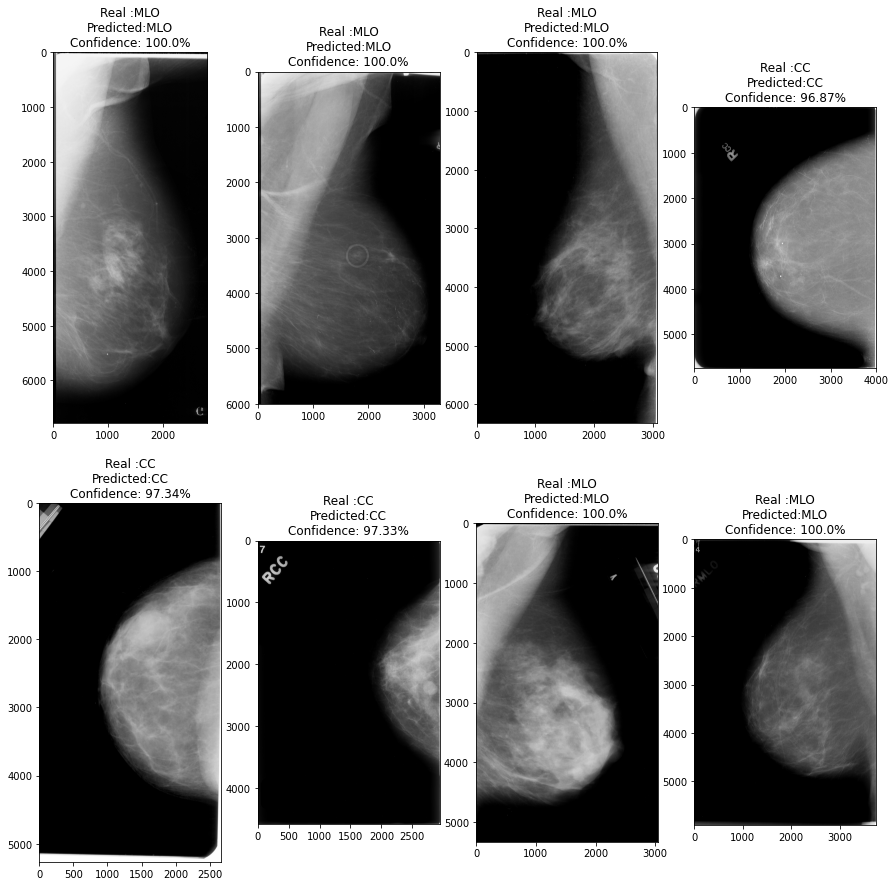

In [40]:
import random
count = 0
basepath = 'CBIS/Png/'
fig, axs = plt.subplots(2, 4, figsize = (15, 15))
for i in range(2):
    ## Generate random number
    n = random.randint(0,len(test))
    data = test.iloc[n]
    img = cv2.imread(basepath + data['Index'])
    axs[count][0].title.set_text(f'Real :{data["Exam Type"]}\nPredicted:{data["PredLabel"]}\nConfidence: {(data["Confidence"]*100).round(2)}%')
    axs[count][0].imshow(img)

    n = random.randint(0,len(test))
    data = test.iloc[n]
    img = cv2.imread(basepath + data['Index'])
    axs[count][1].title.set_text(f'Real :{data["Exam Type"]}\nPredicted:{data["PredLabel"]}\nConfidence: {(data["Confidence"]*100).round(2)}%')
    axs[count][1].imshow(img)
    
    n = random.randint(0,len(test))
    data = test.iloc[n]
    img = cv2.imread(basepath + data['Index'])
    axs[count][2].title.set_text(f'Real :{data["Exam Type"]}\nPredicted:{data["PredLabel"]}\nConfidence: {(data["Confidence"]*100).round(2)}%')
    axs[count][2].imshow(img)
        
    n = random.randint(0,len(test))
    data = test.iloc[n]
    img = cv2.imread(basepath + data['Index'])
    axs[count][3].title.set_text(f'Real :{data["Exam Type"]}\nPredicted:{data["PredLabel"]}\nConfidence: {(data["Confidence"]*100).round(2)}%')
    axs[count][3].imshow(img)
    
    count+=1



In [96]:
test.to_pickle("testmod.pkl")